In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K

In [2]:
TRAIN_DATA_DIR = "../input/train/"
TARGET_SIZE = (224, 224)
BATCH_SIZE=1000

train_data = tf.keras.utils.image_dataset_from_directory(directory=TRAIN_DATA_DIR,
                                                         image_size=TARGET_SIZE,
                                                         batch_size=BATCH_SIZE,
                                                         label_mode=None)

Found 7129 files belonging to 1 classes.


In [3]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_train_data = train_data.map(lambda image: normalization_layer(image))

In [4]:
image_batch = next(iter(normalized_train_data))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


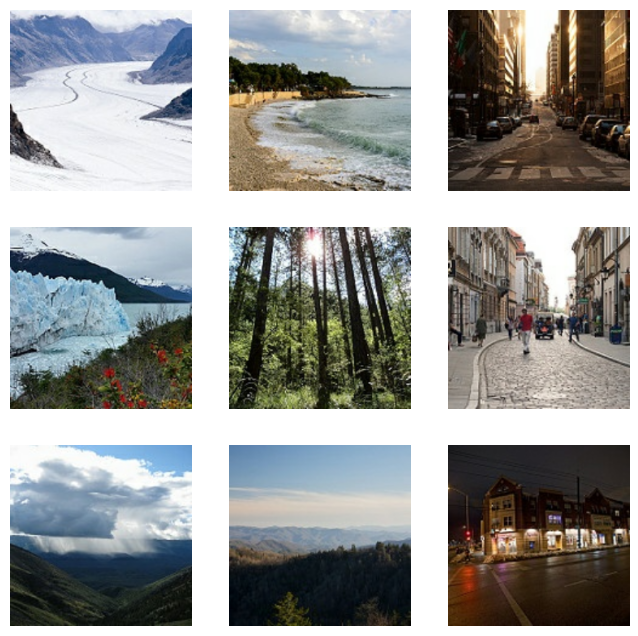

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for image_batch in normalized_train_data.as_numpy_iterator():
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i])
        plt.axis("off")
    break
    
        
plt.show();

In [4]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from skimage.transform import resize, rescale

def convert_rgb_to_lab(img):
    rescale()
    lab_img = rgb2lab(img)
    greyscale_img = np.expand_dims(lab_img[:,:,0], axis=-1) # L-channel
    
    # a and b channel values range from -127 to 128, 
    # so we divide the values by 128 to restrict values to between -1 and 1.
    ab_channel_img = lab_img[:,:,1:]/128
    
    return greyscale_img, ab_channel_img

In [43]:
temp = img_to_array(load_img('../input/train/color/0.jpg'))

greyscale_img, ab_channel_img = convert_rgb_to_lab(temp)

In [44]:
temp.shape

(150, 150, 3)

In [45]:
greyscale_img.shape, ab_channel_img.shape

((150, 150, 1), (150, 150, 2))

In [41]:
type(greyscale_img)

numpy.ndarray

In [59]:
# normalized_train_data.apply(convert_rgb_to_lab)

In [12]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from skimage.transform import resize, rescale

# Set the paths to the training data
color_images_dir = "../input/train/color"

# Set the input image dimensions
input_height, input_width = 224, 224
TARGET_SIZE = (224, 224)
input_channels = 3

# Set the hyperparameters
batch_size = 1000


def convert_rgb_to_lab(img):
    img = img*(1./255)
    
    lab_img = rgb2lab(img)
    greyscale_img = np.expand_dims(lab_img[:,:,0], axis=-1) # L-channel
    
    # a and b channel values range from -127 to 128, 
    # so we divide the values by 128 to restrict values to between -1 and 1.
    ab_channel_img = lab_img[:,:,1:]/128
    
    return greyscale_img, ab_channel_img



# Create a data generator
def data_generator(color_images_paths: list, batch_size: int):
    num_samples = len(color_images_paths)
    while True:
        indices = np.random.choice(num_samples, batch_size, replace=False)
        greyscale_images = []
        ab_channel_images = []

        for index in indices:
            color_img = img_to_array(load_img(color_images_paths[index], target_size=TARGET_SIZE))
            greyscale_img, ab_channel_img = convert_rgb_to_lab(color_img)
            
            greyscale_img = gray2rgb(greyscale_img).reshape((224,224,3))
            
            greyscale_images.append(greyscale_img)
            # greyscale_images.append(color_img)
            ab_channel_images.append(np.array(ab_channel_img))

        yield np.array(greyscale_images), np.array(ab_channel_images)


# Get the paths to color images
color_images_paths = [os.path.join(color_images_dir, filename) for filename in os.listdir(color_images_dir)]

In [13]:
# epochs = 50
# learning_rate = 0.001

# # Set the number of training steps per epoch
steps_per_epoch = len(os.listdir(color_images_dir)) // batch_size

In [15]:
K.clear_session()

In [16]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16()
model = models.Sequential(name='image_coloring_autoencoder_model')

# Adding vgg16 layers to our model
for layer_num, layer in enumerate(base_model.layers):
    if layer_num < 19:
        model.add(layer)


# Freezing those layers as we don't want to train them, just feature extracting from learned weights
for layer in model.layers:
    layer.trainable = False
    
model.summary()

Model: "image_coloring_autoencoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None

In [17]:
model.add(layers.Conv2D(256, (3,3), 
                        activation='relu', padding='same', 
                        input_shape=(7,7,512), name='decoder_layer'))

model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2, 2)))

model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2, 2)))

model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2, 2)))

model.add(layers.Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2, 2)))

model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(layers.UpSampling2D((2, 2)))

model.summary()

Model: "image_coloring_autoencoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None

In [18]:
train_data_generator = data_generator(color_images_paths=color_images_paths,
                                      batch_size=batch_size)

In [20]:
K.clear_session()

In [22]:
%%time
model.compile(optimizer='Adam', 
                      loss='mse', 
                      metrics=['accuracy'])


history = model.fit(train_data_generator, 
                    verbose=1, 
                    epochs=2, 
                    batch_size=1000,
                    steps_per_epoch=steps_per_epoch, 
                    workers=10)

Epoch 1/2


ResourceExhaustedError: Graph execution error:

Detected at node 'image_coloring_autoencoder_model/block1_conv1/Relu' defined at (most recent call last):
    File "C:\ProgramData\anaconda3\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\ProgramData\anaconda3\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\ProgramData\anaconda3\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 728, in start
      self.io_loop.start()
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\ProgramData\anaconda3\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\ProgramData\anaconda3\lib\asyncio\base_events.py", line 1906, in _run_once
      handle._run()
    File "C:\ProgramData\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Amit Vikram Raj\AppData\Local\Temp\ipykernel_12896\1113407503.py", line 1, in <module>
      get_ipython().run_cell_magic('time', '', "model.compile(optimizer='Adam', \n                      loss='mse', \n                      metrics=['accuracy'])\n\n\nhistory = model.fit(train_data_generator, \n                    verbose=1, \n                    epochs=2, \n                    batch_size=1000,\n                    steps_per_epoch=steps_per_epoch, \n                    workers=10)\n")
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2478, in run_cell_magic
      result = fn(*args, **kwargs)
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\IPython\core\magics\execution.py", line 1325, in time
      exec(code, glob, local_ns)
    File "<timed exec>", line 6, in <module>
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'image_coloring_autoencoder_model/block1_conv1/Relu'
OOM when allocating tensor with shape[1000,224,224,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node image_coloring_autoencoder_model/block1_conv1/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_8453]

In [98]:
history.history

{'loss': [0.007035781629383564, 0.006970432586967945],
 'accuracy': [0.7242551445960999, 0.7366392612457275]}

In [99]:
test = img_to_array(load_img('../input/test/t1.jpg'))

test = resize(test, (224,224), anti_aliasing=True)
test*= 1.0/255

lab = rgb2lab(test)

l = lab[:,:,0]
L = gray2rgb(l)
L = L.reshape((1,224,224,3))

# vgg_pred = model.predict(L)
# ab = loaded_model.predict(vgg_pred)
ab = model.predict(L)
ab = ab*128
cur = np.zeros((224, 224, 3))
cur[:,:,0] = l
cur[:,:,1:] = ab

colored_img = lab2rgb(cur)

1/1 [==============================] - 1s 1s/step


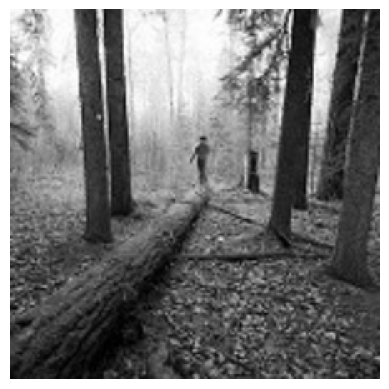

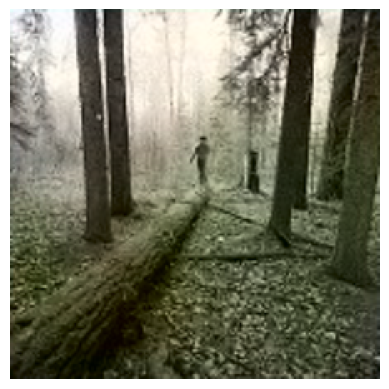

In [100]:
plt.figure()
plt.imshow(test)
plt.axis("off");

plt.figure()
plt.imshow(colored_img)
plt.axis("off");